#### module

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### hyper-parameters

In [3]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

#### dataset

In [4]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [5]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000


In [6]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

#### model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
    
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

In [8]:
model = CNN().to(device)

#### loss

In [9]:
loss_func = nn.CrossEntropyLoss()

#### optimizer

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### train

In [11]:
loss_array = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
        if j%1000 == 0:
            print(loss)
            loss_array.append(loss.cpu().detach().numpy())

tensor(2.3064, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1694, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2379, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0891, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0568, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0958, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0176, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0296, device='cuda:0', grad_fn=<NllLossBackward>)


#### plot

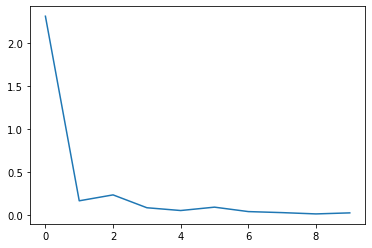

In [12]:
plt.plot(loss_array)
plt.show()

#### test

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y_ = label.to(device)
        
        output = model.forward(x)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == y_).sum().float()
        
    print(f"Accuracy: {(correct/total*100):.8f}")

Accuracy: 98.75801086
